In [42]:
import time
from pandas import read_csv
filename = 'train_imperson_without4n7_balanced_data.csv'
data = read_csv(filename)
data1=data.iloc[:,list(range(152))] # data1 now is a dataset with reduced dimensionality (without last column)
Y_train = data.values[:,-1]
data1.shape

(97044, 152)

In [43]:
data1.head(5)

,1,2,3,5,6,8,9,10,11,12,...,145,146,147,148,149,150,151,152,153,154
0,0,0,0,0.000066,0.000066,0.009150,0.009150,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0.0
1,0,0,0,0.000014,0.000014,0.000000,0.000000,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0.0
2,0,0,0,0.035528,0.035528,0.070588,0.070588,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0.0
3,0,0,0,0.005128,0.005128,0.094771,0.094771,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0.0
4,0,0,0,0.035116,0.035116,0.070588,0.070588,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0.0


In [44]:
#Transform initial data into principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=10,random_state=5)
principalComponents = pca.fit_transform(data1)

In [45]:
import pandas as pd

pca_feat=pd.DataFrame.from_records(principalComponents)

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
pca_feat10 = scaler.fit_transform(pca_feat)

In [47]:
#convert transformed data to a pandas DataFrame
data_new=pd.DataFrame(pca_feat10,columns=[str(i) for i in range(156,166)],dtype='float64')

In [48]:
#Combine 2 tables with original and extracted features (principal components)
data_total=pd.concat([data1,data_new],axis=1)
data_total.head()#Now our matrix has 162 columns including new ones

,1,2,3,5,6,8,9,10,11,12,...,156,157,158,159,160,161,162,163,164,165
0,0,0,0,0.000066,0.000066,0.009150,0.009150,0,0,0,...,0.550640,0.566594,0.146304,0.100256,0.836051,0.696613,0.784784,0.430744,0.337058,0.335958
1,0,0,0,0.000014,0.000014,0.000000,0.000000,0,0,0,...,0.456212,0.892802,0.001978,0.204647,0.472908,0.323808,0.480850,0.507697,0.373927,0.404328
2,0,0,0,0.035528,0.035528,0.070588,0.070588,0,0,0,...,0.055976,0.934653,0.810121,0.298588,0.464161,0.325665,0.379265,0.536603,0.182348,0.245703
3,0,0,0,0.005128,0.005128,0.094771,0.094771,0,0,0,...,0.030435,0.964118,0.912767,0.251484,0.449929,0.320413,0.465086,0.483752,0.338431,0.967214
4,0,0,0,0.035116,0.035116,0.070588,0.070588,0,0,0,...,0.056380,0.934481,0.809766,0.298319,0.464289,0.326487,0.377564,0.538018,0.180630,0.240669


In [49]:
#Extract features for test data
filename2 = 'test_imperson_without4n7_balanced_data.csv'
data2 = read_csv(filename2)

In [50]:
x_t=data2.iloc[:,list(range(152))]
y_t=data2.iloc[:,-1]
pca_t = pca.fit_transform(x_t, y_t)

In [51]:
pca_tt = scaler.fit_transform(pca_t)
test_new=pd.DataFrame(pca_tt,columns=[str(i) for i in range(156,166)],dtype='float64')

In [52]:
test_total=pd.concat([x_t,test_new],axis=1)
test_total.shape

(40158, 162)

In [53]:
data_total.to_csv('pca_data_total.csv',index= False)
test_total.to_csv('pca_test_total.csv',index= False)

In [54]:
from pandas import read_csv

f01='pca_data_total.csv'
TRAIN = read_csv(f01)
f02='pca_test_total.csv'
TEST = read_csv(f02)

In [56]:
import numpy as np
import pandas as pd
from pandas import read_csv
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def best_features(scores,N):
    scores_desc=scores.sort_values(na_position='first')[::-1]
    features=[]
    
    for i in range(N):
        features.append(scores_desc.index[i])
    return features #algorithm sort all features in descending order from most to least important

In [57]:
import time
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from math import sqrt

Y_train = data.values[:,-1]
Y_test=data2.values[:,-1]

def accuracy(matrix,Y_test):
    corr=0
    for i in range(2):
        for j in range(2):
            if i==j:
                corr+=matrix[i][j]
    accuracy=corr/len(Y_test)
    return accuracy

#Function to extract exact features from original train dataset
def train_set(features,data):
    train_set = data.iloc[:,features]
    return train_set

#Function to extract exact features from original test dataset
def test_set(features,data): #features - list of indices
    colnames=TRAIN.columns[features] #list with column names
    test_set=data[colnames]
    return test_set

#function to run model and obtain accuracy and time
def run_model(model,mod,features,train,test): 
    accuracy_mod=[]
    time_mod=[]
    for i in range(3,len(features)+1):
        X_train=train_set(features[:i],train)
        start=time.time()
        model.fit(X_train, Y_train)
        end=time.time()
        elapsed=end-start
        predicted = model.predict(test_set(features[:i],test))
        matrix = confusion_matrix(Y_test, predicted)
        acc=round(accuracy(matrix,Y_test),3)
        accuracy_mod.append(acc)
        time_mod.append(round(elapsed,3))
    return accuracy_mod,time_mod

In [58]:
#1.Univariate FS - Filter method.
test1 = SelectKBest(score_func=chi2, k=20) 
fit1 = test1.fit(TRAIN, Y_train)
# summarize scores
set_printoptions(precision=3)
scores1=pd.Series(fit1.scores_)

features1=best_features(scores1,20)
print(features1)

[68, 48, 64, 44, 153, 151, 47, 5, 6, 65, 79, 67, 70, 143, 142, 91, 63, 127, 152, 74]


In [59]:
TRAIN.columns[features1]

Index(['71', '51', '67', '47', '157', '154', '50', '8', '9', '68', '82', '70',
       '73', '146', '145', '94', '66', '130', '156', '77'],
      dtype='object')

In [60]:
#1a. Filter method - Logistic Regression
m1=LogisticRegression(random_state=5,solver='lbfgs',max_iter=2000)
LR1=run_model(m1,'LR',features1,TRAIN,TEST) #features1 are indices for data_total dataset with 162 columns
print('Accuracy for LR is',LR1[0])
print('Time for LR is',LR1[1])

Accuracy for LR is [0.92, 0.936, 0.936, 0.936, 0.936, 0.938, 0.939, 0.943, 0.977, 0.977, 0.977, 0.977, 0.977, 0.979, 0.979, 0.982, 0.976, 0.971]
Time for LR is [0.807, 0.403, 0.454, 0.622, 0.648, 0.834, 1.041, 1.48, 1.38, 1.482, 1.551, 2.0, 1.871, 1.946, 2.075, 1.946, 2.235, 2.149]


In [61]:
#1c. Filter method - RF
from sklearn.ensemble import RandomForestClassifier

m3=RandomForestClassifier(n_estimators=50,max_features=3,random_state=5)
RF1=run_model(m3,'RF',features1,TRAIN,TEST)
print('Accuracy for RF is',RF1[0])
print('Time for RF is',RF1[1])

Accuracy for RF is [0.92, 0.939, 0.501, 0.502, 0.502, 0.538, 0.533, 0.534, 0.534, 0.535, 0.536, 0.536, 0.534, 0.536, 0.533, 0.536, 0.532, 0.522]
Time for RF is [1.194, 1.303, 4.15, 4.137, 3.976, 3.517, 3.16, 2.76, 2.416, 2.494, 2.474, 2.496, 2.507, 2.337, 2.466, 2.415, 3.065, 3.599]


In [62]:
#3. Feature selection with RFE - Wrapper method.
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

model = LogisticRegression(random_state=5)
rfe = RFE(model, 20)
wrapper = rfe.fit(TRAIN, Y_train)
f3=wrapper.support_
features3=[i for i in range(len(f3)) if f3[i]==True]
print(features3)

[4, 5, 6, 44, 64, 67, 68, 70, 79, 87, 95, 104, 108, 109, 117, 137, 138, 140, 159, 161]


In [63]:
features3=[4, 5, 6, 44, 64, 67, 68, 70, 79, 87, 95, 104, 108, 109, 117, 137, 138, 140, 159, 161]
#Base line
m1=LogisticRegression(random_state=5,solver='lbfgs')
LR3b=run_model(m1,'LR',features3,TRAIN,TEST)
print('Accuracy for LR is',LR3b[0])
print('Time for LR is',LR3b[1])

Accuracy for LR is [0.696, 0.878, 0.941, 0.942, 0.943, 0.942, 0.972, 0.977, 0.977, 0.977, 0.977, 0.978, 0.98, 0.518, 0.531, 0.531, 0.526, 0.498]
Time for LR is [0.708, 0.368, 0.526, 0.641, 0.469, 0.725, 0.633, 1.171, 1.277, 1.303, 1.251, 1.304, 1.476, 1.292, 1.347, 1.4, 1.572, 1.414]


In [67]:
#2a. Wrapper method - Logistic Regression
import warnings
warnings.filterwarnings("ignore")

#Justification for this feature set see below
m1=LogisticRegression(random_state=5,solver='lbfgs')
LR3=run_model(m1,'LR',[159,4, 5, 6, 44, 64, 67, 68, 70, 79, 87, 95, 104, 108, 109, 117, 137, 138, 140,161],TRAIN,TEST)
print('Accuracy for LR is',LR3[0])
print('Time for LR is',LR3[1])

Accuracy for LR is [0.427, 0.427, 0.568, 0.936, 0.945, 0.599, 0.599, 0.601, 0.986, 0.986, 0.986, 0.986, 0.986, 0.985, 0.525, 0.526, 0.526, 0.498]
Time for LR is [0.356, 0.262, 0.576, 0.547, 0.579, 0.499, 0.762, 0.876, 1.266, 1.521, 1.273, 1.49, 1.512, 1.632, 1.679, 1.592, 1.637, 1.45]


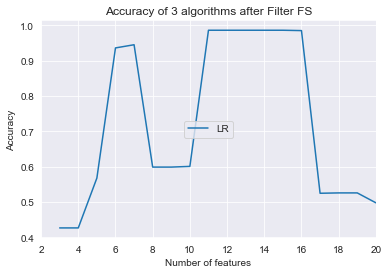

In [80]:
#Accuracy of visualisation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
axes = plt.gca()
axes.set_xlim([2,20])
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Accuracy of 3 algorithms after Filter FS')
plt.plot(list(range(3,21)),LR3[0])
plt.legend(['LR'], loc='center')
plt.show()

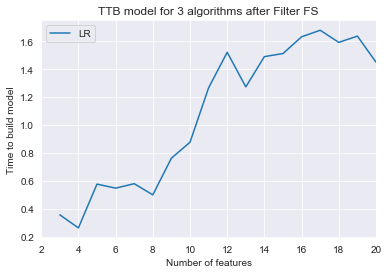

In [81]:
#Time to build model visualisation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
axes = plt.gca()
axes.set_xlim([2,20])
plt.xlabel('Number of features')
plt.ylabel('Time to build model')
plt.title('TTB model for 3 algorithms after Filter FS')
plt.plot(list(range(3,21)),LR3[1])
plt.legend(['LR'], loc='upper left')
plt.show()

In [68]:
#Mapping column indices and column names
attributes = pd.read_csv('attributes.csv')
names = list(attributes['attributes'])
numbers=list(data.columns)#till 155 elementh
D_attr={}
for i in range(len(numbers)):
    D_attr[numbers[i]]=names[i]
print(D_attr)

{'1': 'frame.interface_id', '2': 'frame.dlt', '3': 'frame.offset_shift', '5': 'frame.time_delta', '6': 'frame.time_delta_displayed', '8': 'frame.len', '9': 'frame.cap_len', '10': 'frame.marked', '11': 'frame.ignored', '12': 'radiotap.version', '13': 'radiotap.pad', '14': 'radiotap.length', '15': 'radiotap.present.tsft', '16': 'radiotap.present.flags', '17': 'radiotap.present.rate', '18': 'radiotap.present.channel', '19': 'radiotap.present.fhss', '20': 'radiotap.present.dbm_antsignal', '21': 'radiotap.present.dbm_antnoise', '22': 'radiotap.present.lock_quality', '23': 'radiotap.present.tx_attenuation', '24': 'radiotap.present.db_tx_attenuation', '25': 'radiotap.present.dbm_tx_power', '26': 'radiotap.present.antenna', '27': 'radiotap.present.db_antsignal', '28': 'radiotap.present.db_antnoise', '29': 'radiotap.present.rxflags', '30': 'radiotap.present.xchannel', '31': 'radiotap.present.mcs', '32': 'radiotap.present.ampdu', '33': 'radiotap.present.vht', '34': 'radiotap.present.reserved', '

In [69]:
#step to create final CSV
featurization=list(TRAIN.columns[[159,4, 5, 6, 44, 64, 67, 68, 70, 79, 87, 95, 104, 108, 109, 117, 137, 138, 140,161]]) #data_red - reduced dataset
#featurization.append('155')

In [70]:
#Select subset from data according to particular features
featurization_pca_train=TRAIN[featurization] #dataset with indices as column names
featurization_pca_test=TEST[featurization]

In [71]:
colnames=[]
for i in featurization:
    if int(i)<155:
        colnames.append(D_attr[i]) #make new list with column names according to indices
    else:
        colnames.append(i)
featurization_pca_train.columns = colnames 
featurization_pca_test.columns = colnames 

In [72]:
featurization_pca_train['class']=Y_train
featurization_pca_test['class']=data2.iloc[:,-1]

In [73]:
featurization_pca_train.to_csv('featurization_pca_train.csv',index= False)
featurization_pca_test.to_csv('featurization_pca_test.csv', index= False)

In [74]:
#Double checking the result

data_train = pd.read_csv("featurization_pca_train.csv")
data_test = pd.read_csv("featurization_pca_test.csv")
train_xx=data_train.iloc[:,:12]
train_yy=data_train.iloc[:,-1]
test_xx=data_test.iloc[:,:12]
test_yy=data_test.iloc[:,-1]
modlr=LogisticRegression(random_state=5,solver='lbfgs')
modlr.fit(train_xx, train_yy)
predicted = modlr.predict(test_xx)
matrix = confusion_matrix(test_yy, predicted)
acc=round(accuracy(matrix,test_yy),3)
print(acc)

0.986


In [75]:
#Justification that we should shift one feature
Iter={}
for i in range(5,20):
    allfeat=[4, 5, 6, 44, 64, 67, 68, 70, 79, 87, 95, 104, 108, 109, 117, 137, 138, 140, 159, 161]
    allfeat.insert(0,allfeat.pop(i))
    LRz=run_model(m1,'LR',allfeat,TRAIN,TEST)
    Iter[i]=max(LRz[0])
Iter

{5: 0.98,
 6: 0.98,
 7: 0.98,
 8: 0.98,
 9: 0.98,
 10: 0.98,
 11: 0.98,
 12: 0.98,
 13: 0.98,
 14: 0.98,
 15: 0.972,
 16: 0.943,
 17: 0.979,
 18: 0.986,
 19: 0.941}

In [ ]:
#with feature N159 we obtained best result.

In [78]:
#List of 12 best features for intrusion detection using PCA
list(train_xx)

['163',
 'frame.time_delta_displayed',
 'frame.len',
 'frame.cap_len',
 'radiotap.datarate',
 'wlan.fc.subtype',
 'wlan.fc.retry',
 'wlan.fc.pwrmgt',
 'wlan.fc.protected',
 'wlan.seq',
 'wlan_mgt.fixed.capabilities.ess',
 'wlan_mgt.fixed.capabilities.short_slot_time']